---

<h1 style="text-align: center;font-size: 40px;color: magenta">Fake News Classifier using LSTM</h1>

---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newscsv/news.csv


In [2]:
df = pd.read_csv("../input/newscsv/news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df['label'] = pd.factorize(df['label'])[0]
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [4]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

>We have so many Null values ,so let's drop these Null Values

In [5]:
df = df.dropna()

> <h4>We are going to use "Title" to classify our News is Fake or Real,So "title" is our Independent variable,whereas our target is to detect our News is Fake or Not,So here our dependent/target variable is label,So Let's get the Independent & Dependent variable</h4>

In [6]:
x = df.drop(['label','Unnamed: 0'],axis = 1)
y = df['label']

> <h3>Now  let's import Necessary libraries for LSTM</h3>

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Embedding,LSTM,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

>Data Preprocessing

In [8]:
messages = x.copy()
##Since we drop Null values from our Dataset ,so we need to Reset Index of our Dataset
messages.reset_index(inplace=True)

>Import necessary libraries for data preprocessing

In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [10]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

> <h3> Some important information: </h3>

- re.sub()
  -  Replace with regular expression
  -  Replace multiple substrings with the same string
  -  Replace using the matched part
  -  Get the count of replaced parts
  - Here we are going to replace all regural expression which are not between a to z or A to Z with whitespace.

- result.lower:
 - By this we are going to replace all the words in Lower case,So that all are treated as equally

- ps.stem()
 -  Stemming is the process of producing morphological variants of a root/base word. Stemming programs are    
    commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words 
    “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” 
    reduce to the stem “retrieve”

In [11]:
ps = PorterStemmer()
corpus = []
for i in range(0,len(messages)):
    result = re.sub('[^a-zA-Z]',' ',messages['title'][i])  
    result = result.lower()
    result = result.split()
    
    result = [ps.stem(word) for word in result if not word in stopwords.words("english")]
    result = " ".join(result)
    corpus.append(result)

In [12]:
corpus

['smell hillari fear',
 'watch exact moment paul ryan commit polit suicid trump ralli video',
 'kerri go pari gestur sympathi',
 'berni support twitter erupt anger dnc tri warn',
 'battl new york primari matter',
 'tehran usa',
 'girl horrifi watch boyfriend left facetim',
 'britain schindler die',
 'fact check trump clinton command chief forum',
 'iran reportedli make new push uranium concess nuclear talk',
 'three clinton iowa glimps fire elud hillari clinton campaign',
 'donald trump shockingli weak deleg game somehow got even wors',
 'strong solar storm tech risk today news oct video',
 'way america prepar world war',
 'trump take cruz lightli',
 'women lead differ',
 'shock michel obama hillari caught glamor date rape promot',
 'hillari clinton huge troubl america notic sick thing hidden pictur liberti writer news',
 'iran bill obama like',
 'chart explain everyth need know partisanship america',
 'slipperi slope trump propos ban muslim',
 'episod sunday wire hail deplor special g

> <h3> One Hot representation</h3>

In [13]:
#Vocabulary Size
voc_size = 5000
onehot_repr = [one_hot(words,voc_size) for words in corpus]
onehot_repr

[[3753, 4787, 2538],
 [3795, 1175, 1271, 1764, 2786, 1390, 3077, 2877, 2079, 4327, 1574],
 [2582, 487, 656, 1645, 3543],
 [4792, 3872, 3331, 3700, 604, 1633, 564, 4000],
 [675, 4094, 4828, 2109, 3288],
 [1428, 4833],
 [4987, 2264, 3795, 4772, 1639, 2143],
 [568, 1878, 1799],
 [4991, 1217, 2079, 4312, 1854, 4582, 1137],
 [75, 3671, 2177, 4094, 1740, 4962, 1852, 2925, 4660],
 [1058, 4312, 1147, 1580, 708, 1136, 4787, 4312, 4477],
 [1151, 2079, 785, 200, 685, 3813, 2342, 1877, 3831, 4157],
 [4752, 2596, 2436, 2163, 3054, 129, 1086, 231, 1574],
 [4558, 2680, 1927, 693, 501],
 [2079, 3750, 3138, 20],
 [4502, 2068, 830],
 [3753, 664, 4188, 4787, 1351, 2630, 4015, 3070, 1981],
 [4787, 4312, 1575, 2996, 2680, 1170, 2096, 2317, 654, 2396, 576, 1923, 1086],
 [75, 3808, 4188, 181],
 [1537, 3007, 958, 700, 312, 797, 2680],
 [4699, 2412, 2079, 1439, 400, 982],
 [1545, 4237, 299, 3238, 2416, 3420, 4212, 2887, 294],
 [4787, 4312, 2177, 2675, 4829, 2419, 723],
 [4094, 1114, 1395, 2749, 4042, 1370, 302

>Embedding Representation

- Pad_Sequences:
 - The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences.
   The default padding value is 0.0, which is suitable for most applications, although this can be changed by      specifying the preferred value via the “value” argument.
  - By this we are going to make all the sentances in same length.There are 2 types of Padding "Pre" and 
   "Post",pre means it's going to add 0 in front and post means it's goint add 0 in back

In [14]:
sent_length = 20
embeded_docs = pad_sequences(onehot_repr,padding= 'pre',maxlen = sent_length)
embeded_docs

array([[   0,    0,    0, ..., 3753, 4787, 2538],
       [   0,    0,    0, ..., 2079, 4327, 1574],
       [   0,    0,    0, ...,  656, 1645, 3543],
       ...,
       [   0,    0,    0, ...,  833, 1991, 4329],
       [   0,    0,    0, ...,  267, 2137, 1127],
       [   0,    0,    0, ...,  101, 2079, 3288]], dtype=int32)

In [15]:
embeded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 3753, 4787, 2538], dtype=int32)

> <h3>Creating Model</h3>

In [16]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length = sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',loss ='binary_crossentropy',metrics=['accuracy'])

In [17]:
x_final = np.array(embeded_docs)
y_final = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(x_final,y_final,test_size=0.3,random_state=40)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train,y_train,validation_data =(x_test,y_test),batch_size=64,epochs=10)

Epoch 1/10
70/70 [==============================] - 2s 29ms/step - loss: 0.6670 - accuracy: 0.5891 - val_loss: 0.5776 - val_accuracy: 0.6854
Epoch 2/10
70/70 [==============================] - 2s 23ms/step - loss: 0.4427 - accuracy: 0.8015 - val_loss: 0.4482 - val_accuracy: 0.7938
Epoch 3/10
70/70 [==============================] - 2s 24ms/step - loss: 0.3115 - accuracy: 0.8751 - val_loss: 0.4561 - val_accuracy: 0.7896
Epoch 4/10
70/70 [==============================] - 2s 24ms/step - loss: 0.2441 - accuracy: 0.9003 - val_loss: 0.4950 - val_accuracy: 0.7833
Epoch 5/10
70/70 [==============================] - 2s 23ms/step - loss: 0.1941 - accuracy: 0.9240 - val_loss: 0.5403 - val_accuracy: 0.7717
Epoch 6/10
70/70 [==============================] - 2s 23ms/step - loss: 0.1542 - accuracy: 0.9411 - val_loss: 0.6378 - val_accuracy: 0.7691
Epoch 7/10
70/70 [==============================] - 2s 23ms/step - loss: 0.1378 - accuracy: 0.9493 - val_loss: 0.6905 - val_accuracy: 0.7585
Epoch 8/10
70

In [20]:
import matplotlib.pyplot as plt
def plot_learning_curve(history,epochs):
    #Accuracy
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc ="upper left")
    plt.show()

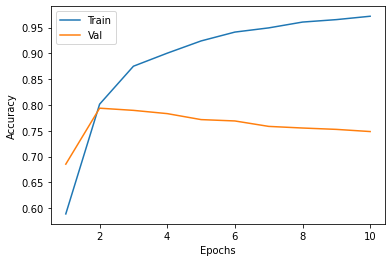

In [21]:
plot_learning_curve(history,10)

- So We should train our model by 2 epochs,Because at 2 epochs we are getting a Perfect model with perfect accuracy for both train & validation

>Performance Matrics & Accuracy

In [22]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test,y_pred)

0.7485533929510784

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f90180fc050>)

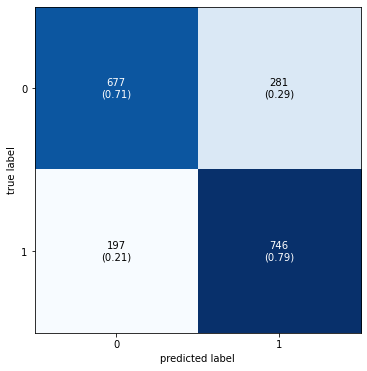

In [23]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(6,6),show_normed=True)

---

<h1 style="text-align: center;font-size: 20px;color: magenta">Thanks for reading the Notebook</h1>

---